In [1]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

2025-04-19 13:58:42.300739: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 13:58:42.303299: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 13:58:42.355443: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 13:58:42.356575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-19 13:58:43.257114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
csv = "../../data/cleaned/problemes_complet_classification.csv"
df = pd.read_csv(csv)

In [4]:
df.shape

(3331, 6)

In [25]:
df_lung = df[(df['problem_category'] == "lung") | (df['problem_category'] == "heart & lung")][['report']].reset_index(drop=True)
df_heart = df[df['problem_category'] == "heart"][['report']].reset_index(drop=True)

print(f" Poumon : {len(df_lung)} lignes")
print(f" Cœur : {len(df_heart)} lignes")

 Poumon : 1131 lignes
 Cœur : 136 lignes


In [26]:
df_lung

,report
0,borderline cardiomegaly midline sternotomy enl...
1,diffuse bilateral interstitial alveolar opacit...
2,cardiomediastinal silhouette pulmonary vascula...
3,cardiac contour normal basilar_atelectasis lun...
4,eamination consists frontal lateral radiograph...
...,...
1126,pneumothora pleural effusion airspace consolid...
1127,acute_osseous_abnormality left_midlung basilar...
1128,similar mild_cardiomegaly pulmonary vascularit...
1129,cardiomediastinal silhouette pulmonary vascula...


In [27]:
df_heart

,report
0,cardiac_silhouette borderline enlarged otherwi...
1,heart mildly heart enlarged mediastinal contou...
2,mild cardiomegaly tortuous aorta focal infiltr...
3,stable cardiomediastinal silhouette mild cardi...
4,chest comparison 26 cm diameter masslike densi...
...,...
131,eamination somewhat_limited_costophrenic poste...
132,lung clear bilaterally specifically evidence f...
133,cardiomegaly focal consolidation pleural effus...
134,apical lordotic frontal view considering diffe...


In [28]:
df

,Problems,report,label,problem_category,terme_coeur,terme_poumon
0,normal,cardiac silhouette mediastinum size within nor...,NaN,other,NaN,NaN
1,cardiomegalypulmonary artery,borderline cardiomegaly midline sternotomy enl...,NaN,heart & lung,cardiomegaly,pulmonary
2,pulmonary disease chronic obstructivebullous e...,diffuse bilateral interstitial alveolar opacit...,poumon,lung,NaN,"pulmonary, emphysema, fibrosis"
3,osteophytethickeninglung,cardiomediastinal silhouette pulmonary vascula...,poumon,lung,NaN,lung
4,normal,heart size mediastinal contour within normal l...,NaN,other,NaN,NaN
...,...,...,...,...,...,...
3326,cardiomegalydiaphragm,heart mildly enlarged left hemidiaphragm eleva...,coeur,heart,cardiomegaly,NaN
3327,cardiomegalypulmonary congestionheart failure,similar mild_cardiomegaly pulmonary vascularit...,NaN,heart & lung,"heart, cardiomegaly",pulmonary
3328,lungdiaphragmcicatripulmonary atelectasispulmo...,cardiomediastinal silhouette pulmonary vascula...,poumon,lung,NaN,"lung, pulmonary, emphysema, atelectasis"
3329,spine,lung clear heart size normal pneumothora endpl...,NaN,other,NaN,NaN


In [29]:
def contamination_function_bis(data1, data2, contamination_rate=0.2):
    """
    Fonction qui génère des anomalie dans notre jeu de données data1, en injectant des donnée de data2.
    
    - data1 : Corpus de données sain
    - data2 : Corpus de données considérées "anomalie"
    - contamination_rate : le taux de document contaminé par rapport a la taille de data1
    
    retourne un nouveau corpus de données avec des anomalies + les indices des anomalies
    """
    contamination_log = []
    
    #on contamine % des documents dans data1 
    df_size = max(1, int(len(data1) * contamination_rate))  
    selected_indices = random.sample(range(len(data1)), df_size)
    
    for i in selected_indices:
        base_text = data1[i]
        new_text = random.choice(data2)
        data1[i] = new_text  # remplacement de la ligne 

        # un log pour surveiller le fonctionnement de la fonction (à ajouter dans le return)
        contamination_log.append({
            "base_text": base_text,  # le texte original avant remplacement
            "contaminated_text": new_text,  # le texte après remplacement
            "index_replaced": i  # l'index de la ligne modifiée
        })

    return data1, selected_indices

In [30]:
new_df, indice = contamination_function_bis(df_lung['report'], df_heart['report'] )

In [31]:
def vetorisation_sbert(data, indice_anomalie=None):
    model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : noraml)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(40, 20)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

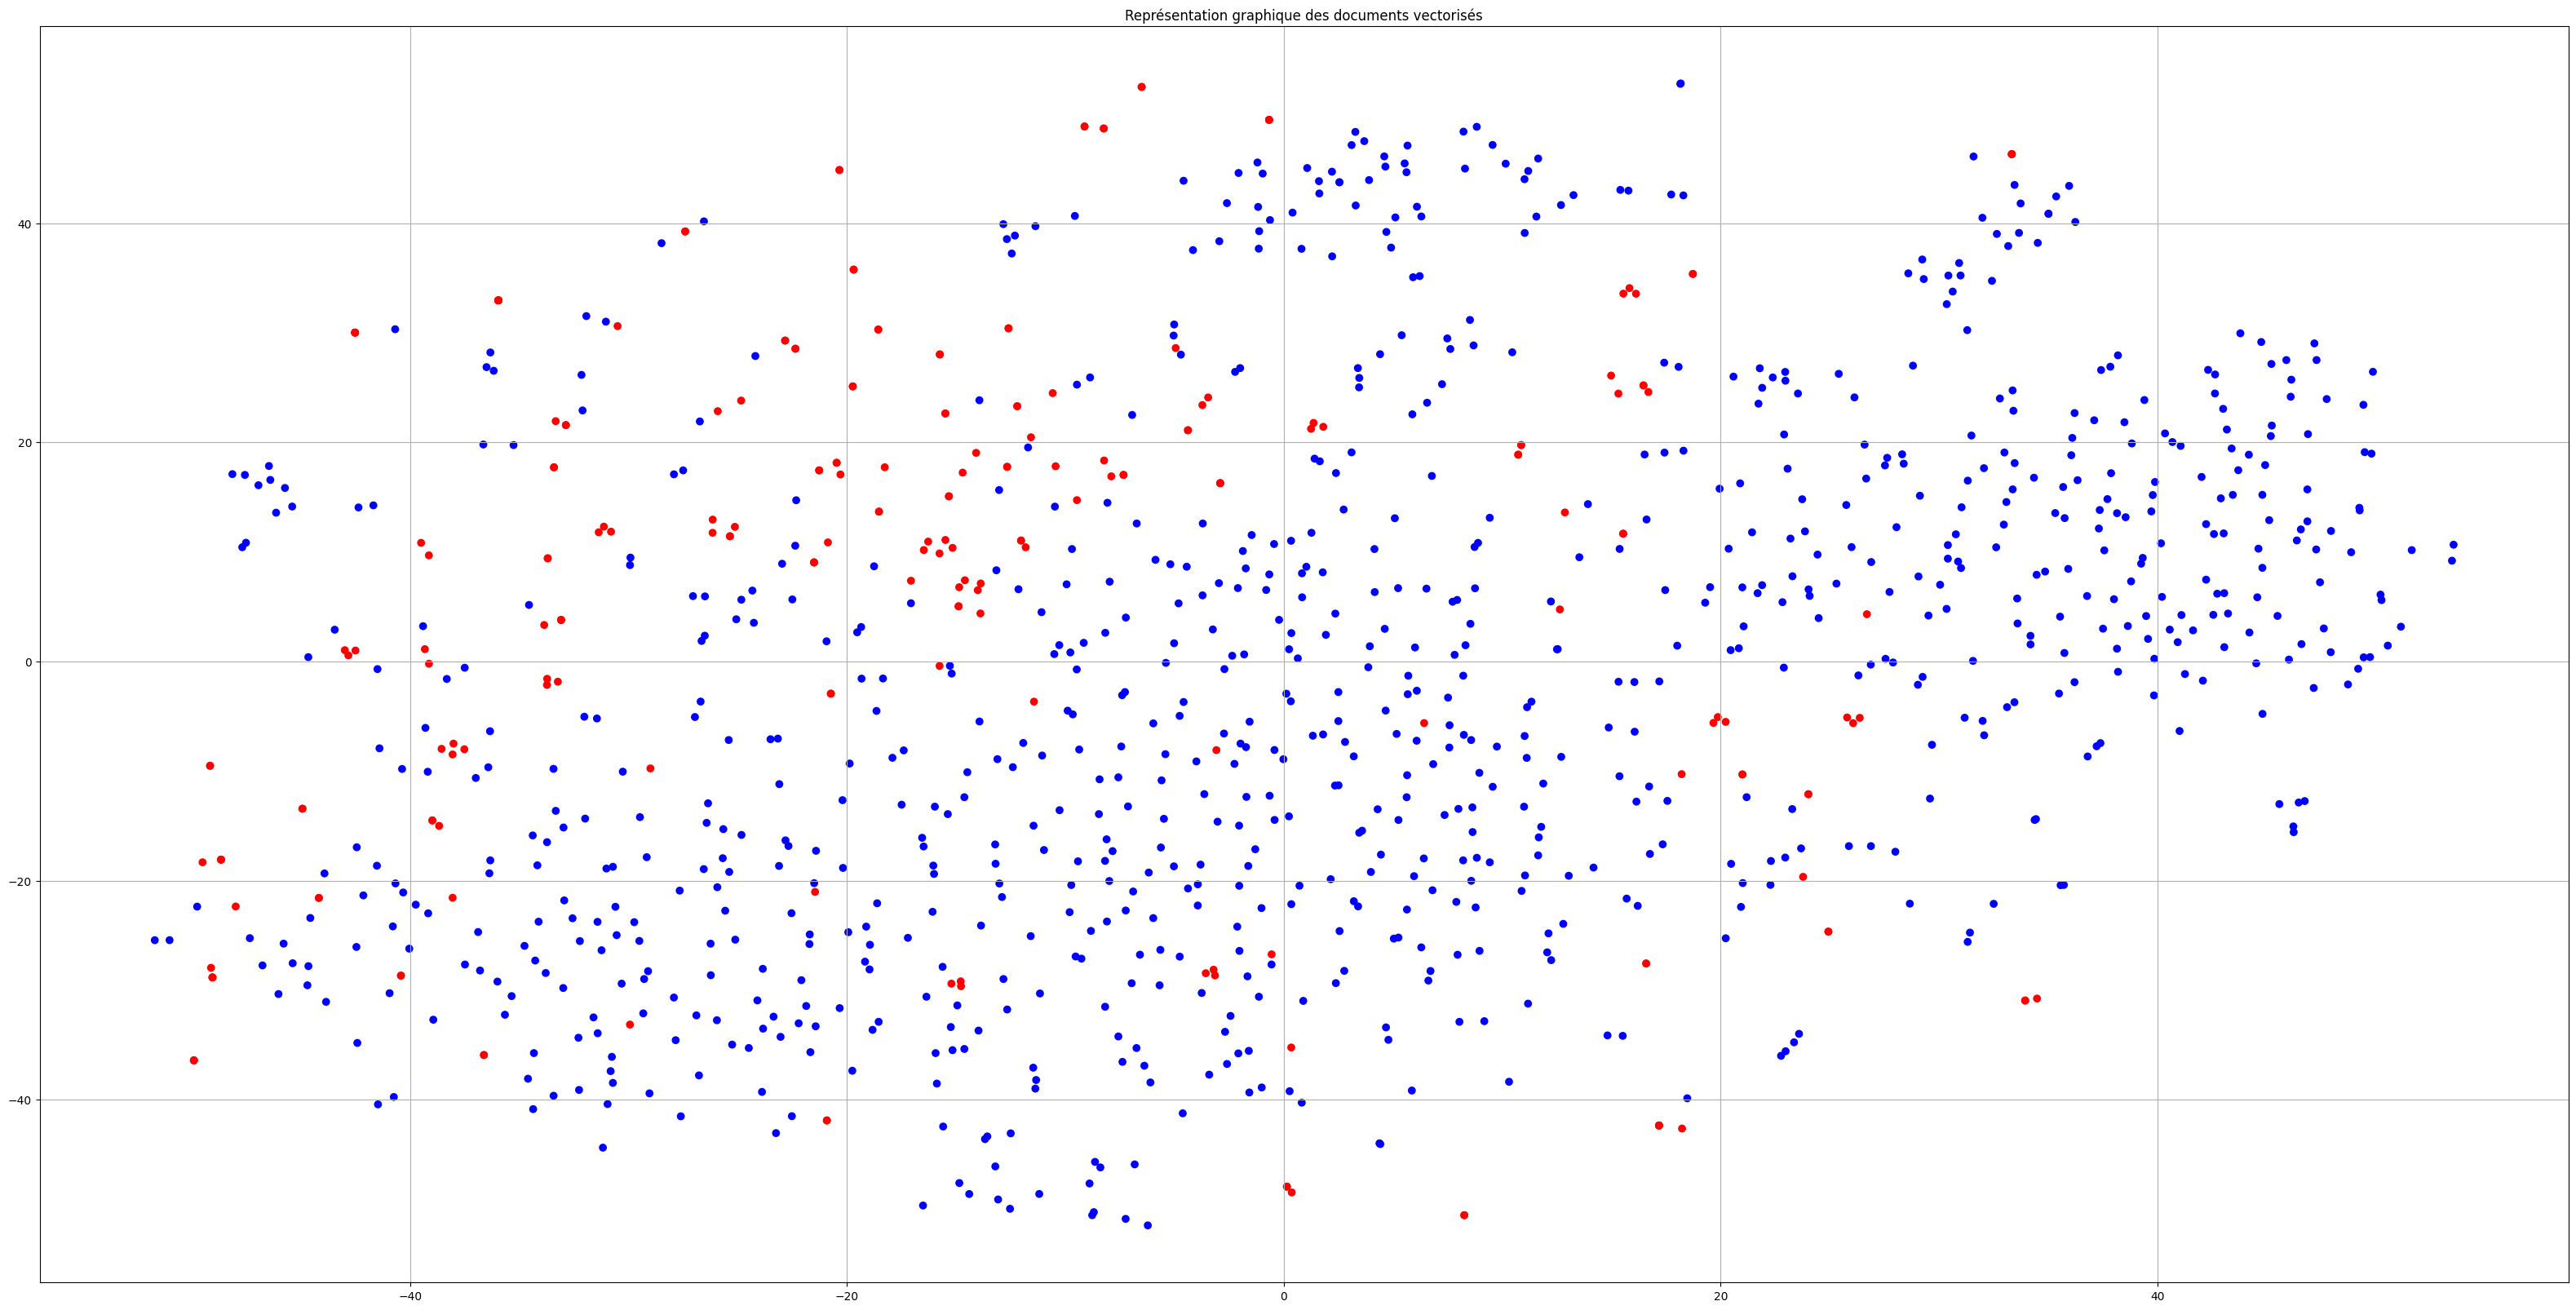

array([[-0.026437  ,  0.00887893,  0.0299234 , ..., -0.04342516,
        -0.07152894,  0.02065541],
       [-0.05143028, -0.0131712 ,  0.03009287, ..., -0.0635815 ,
        -0.01990736, -0.00188441],
       [-0.0432192 ,  0.00667998,  0.00089565, ..., -0.09958749,
         0.01188606,  0.00163743],
       ...,
       [-0.05520723, -0.00882889,  0.01244259, ..., -0.03845733,
        -0.02697534, -0.01058339],
       [-0.05010736, -0.01677608,  0.00014712, ..., -0.0954692 ,
         0.02729561, -0.00662892],
       [-0.04345437, -0.03125473,  0.00432703, ..., -0.00754104,
        -0.03773336, -0.005634  ]], dtype=float32)

In [32]:
vetorisation_sbert(new_df, indice)

In [33]:
new_df.to_csv('../../data/contaminated/contaminated_data_bis.csv', index=False)

In [34]:
np.save("../../data/contaminated/indices_anomalies_bis.npy", indice)